# This notebook was used for training and experimenting with different models

In [2]:
import detectron2
import torch, torchvision
from utils.dataset import *
from utils.evaluation.evaluator import *
from utils.trainer import MTSDTrainer

from detectron2.data import DatasetCatalog
# from detectron2.utils.logger import setup_logger
# setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from datetime import datetime


# from detectron2_backbone import backbone
# from detectron2_backbone.config import add_backbone_config

#import the COCO Evaluator to use the COCO Metrics
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


# Prepare Dataset

In [3]:
#l_id_f="/home/pkost/workspace/inzynierka/inz/lbl_id_dict.pkl"
l_id_f="/home/pkos/workspace/inz/praca_inzynierska/lbl_id_map.pkl"
with open(l_id_f, 'rb') as f:
        lbl_id_map = pickle.load(f)
labels = list(lbl_id_map.keys())
len(labels)

109

In [4]:
ann_d="/mnt/CommonData/dataset/filtered_annotations_2/"
#img_d="/mnt/CommonData/dataset/images/"
img_d="/home/pkos/Desktop/mtsd_fully_annotated/images"
for d in ["train", "val"]:
    #id_f="/mnt/CommonData/dataset/splits/"+ d +".txt"
    #id_f="/mnt/CommonData/dataset/mtsd_fully_annotated/splits/"+ d +".txt"
    id_f="/home/pkos/Desktop/mtsd_fully_annotated/splits/" + d +".txt"
    
    if d=="train":
        DatasetCatalog.register("MTSD_"+d, 
                            lambda id_f=id_f, ann_d=ann_d, img_d=img_d, l_id_f=l_id_f: 
                                prepare_MTSD_for_detectron(id_f, ann_d, img_d, l_id_f))
    else:
        DatasetCatalog.register("MTSD_"+d, 
                            lambda id_f=id_f, ann_d=ann_d, img_d=img_d, l_id_f=l_id_f: 
                                prepare_MTSD_for_detectron(id_f, ann_d, img_d, l_id_f))
    MetadataCatalog.get("MTSD_" + d).set(thing_classes=labels)
    
signs_metadata = MetadataCatalog.get("MTSD_train")

In [5]:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("MTSD_train", {}, "/content/train/_annotations.coco.json", "/content/train")
# register_coco_instances("MTSD_val", {}, "/content/valid/_annotations.coco.json", "/content/valid")

In [6]:
with open('dataset_dicts.pkl', 'rb') as f:
    dataset_dicts = pickle.load(f)

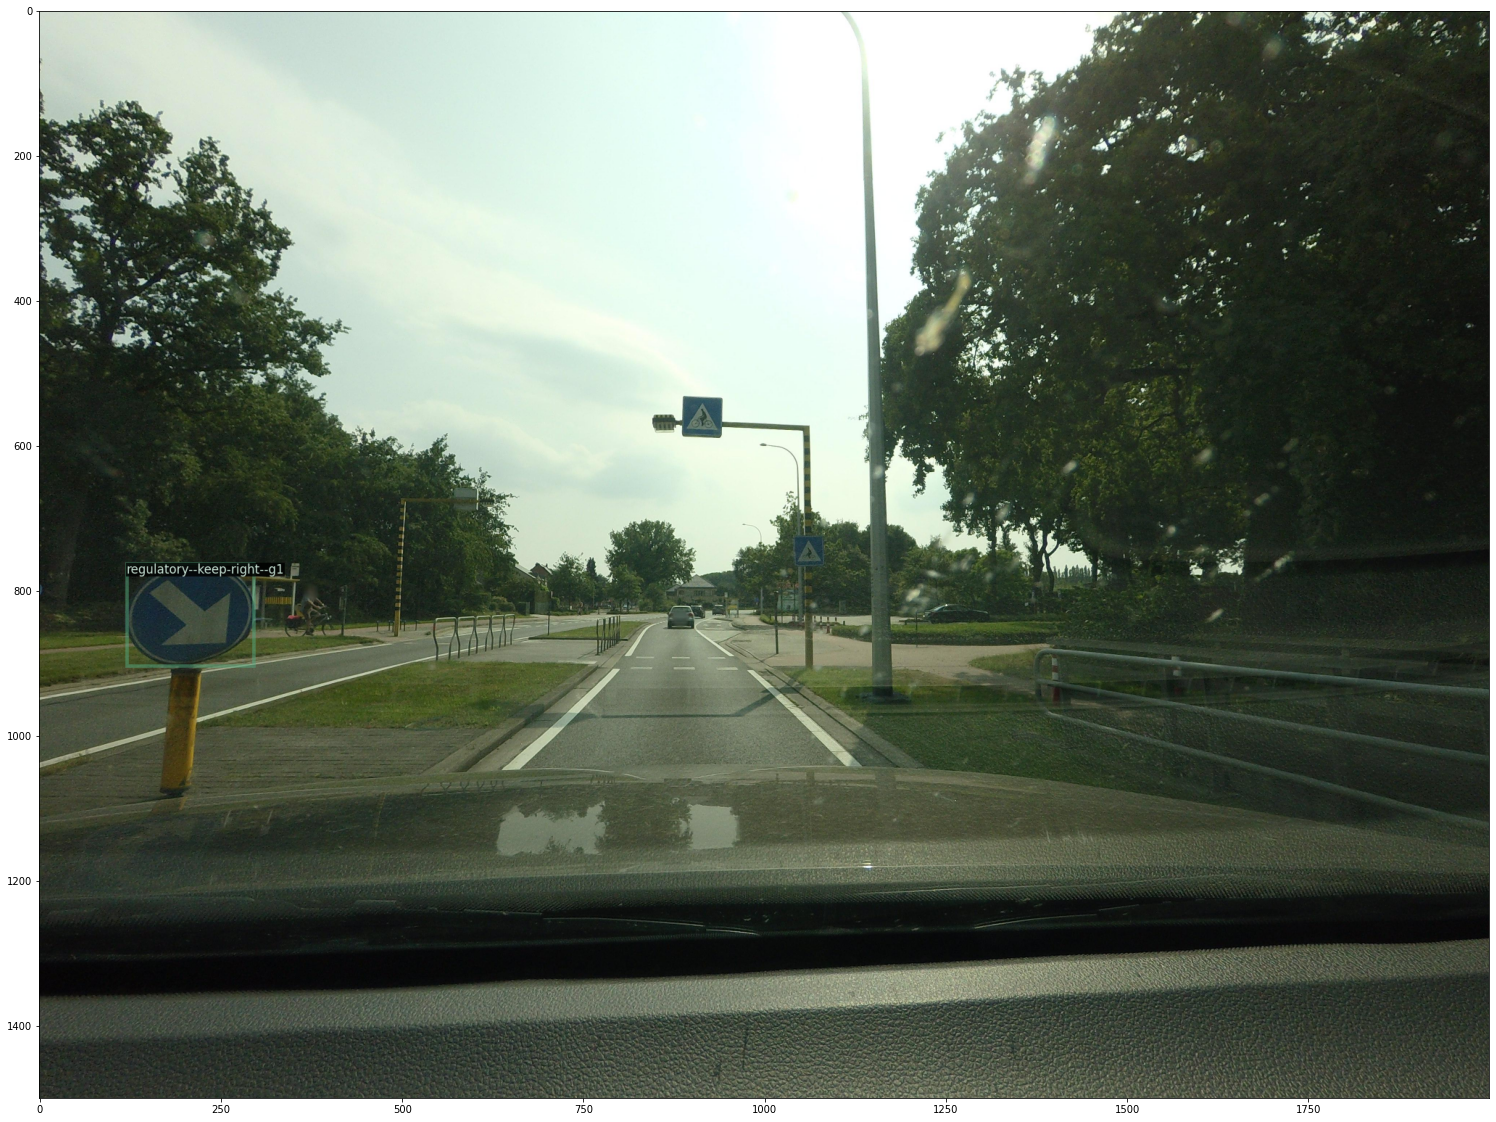

In [7]:
#plot sample image
plt.figure(figsize=(30,20))
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    visualizer = Visualizer(img[:, :, ::-1], metadata=signs_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image())

# Train
####  fine-tune a COCO-pretrained retinanet_R_50 model on the MTSD dataset

In [8]:
#l.iteracji:(N / B) * E, where N stands for Number of Images, B stands for Batch Size, and E means epochs, or how many times we want our model to see each image.
cfg = get_cfg()
#add_backbone_config(cfg)

cfg.OUTPUT_DIR =f"./tboard_logs/retinanet_2020-10-22T17:15_resize_br_ctrst_crop_70_85_rotate_lr0_001"#retinanet_{datetime.now().isoformat().rsplit(':', 1)[0]}_resize_br_ctrst_crop_75_90_rotate_lr0_001/"
#cfg.OUTPUT_DIR = f"./tboard_logs/retinanet_augm_dev/"
#to potrzebuje 4gb:
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))

#Fast_rcnn odpada - https://github.com/facebookresearch/detectron2/issues/1279
#cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/fast_rcnn_R_50_FPN_1x.yaml"))

cfg.DATASETS.TRAIN = ("MTSD_train",)
cfg.DATASETS.TEST = ("MTSD_val",)
cfg.DATALOADER.NUM_WORKERS = 2

# cfg.MODEL.BACKBONE.NAME = "build_fcos_resnet18_fpn_backbone"
#cfg.MODEL.BACKBONE.NAME = "build_fcos_mnv2_fpn_backbone"

# cfg.MODEL.BACKBONE.NAME = "build_fcos_efficientnet_fpn_backbone"
#cfg.MODEL.DEVICE="cuda"

cfg.MODEL.WEIGHTS= model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")  #None # Let training initialize from model zoo
cfg.MODEL.META_ARCHITECTURE = 'RetinaNet'
cfg.MODEL.RETINANET.NUM_CLASSES = len(labels) + 1

cfg.SOLVER.IMS_PER_BATCH = 1#2#default 16
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.WARMUP_ITERS = 5000
cfg.SOLVER.GAMMA = 0.33
cfg.SOLVER.STEPS = (14_000, 40_000, 80_000, 120_000, 160_000)#(14_000, 40_000, 70_000, 100_000, 130_000, 160_000)
cfg.SOLVER.MAX_ITER = 195_000
#cfg.MODEL.RETINANET.IMS_PER_BATCH = 2
#cfg.MODEL.RETINANET.BATCH_SIZE_PER_IMAGE = 64   #faster, and good enough for this toy dataset (default: 512)
cfg.INPUT.CROP.ENABLED=True
#[H, W]
cfg.INPUT.CROP.SIZE=[0.75,0.9]#[0.65,0.75]

#(704, 720, 774, 809, 844, 880) dla ims_per_batch=2
#(480, 504, 528, 552, 576, 600) dla ims_per_batch=3
cfg.INPUT.MIN_SIZE_TRAIN = (1224, 1312, 1836)#(1080, 1100, 1144, 1170, 1184, 1836)#(774, 808, 844, 880, 900, 910)#(740, 774, 808, 844, 880, 900)
cfg.INPUT.MIN_SIZE_TEST = 1080#(256,) #def 800
cfg.INPUT.MAX_SIZE_TRAIN = 2182#(1024,) #def 1333
cfg.INPUT.MAX_SIZE_TEST = 2182#(1024,) #def 1333

cfg.TEST.EVAL_PERIOD = 600_000 # 5000 #200
cfg.SOLVER.CHECKPOINT_PERIOD = 5000
cfg.VIS_PERIOD = 5_000
cfg.TEST.DETECTIONS_PER_IMAGE = 10

Loading config /home/pkos/miniconda3/envs/roadeye/lib/python3.8/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [8]:
#print(cfg)
tuple([int(1.3*x) for x in (774, 808, 844, 880, 900, 910)])
#(768, 806, 844, 883, 921, 960) dla ims_per_batch=2
#(480, 504, 528, 552, 576, 600) dla ims_per_batch=3

(1006, 1050, 1097, 1144, 1170, 1183)

In [9]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
with open(cfg.OUTPUT_DIR + "/config_2.yml", "w") as f:
    f.write(cfg.dump())

# cfg = get_cfg()
# cfg.merge_from_file(cfg.OUTPUT_DIR + "/config.yml")


In [10]:
%%time
torch.cuda.empty_cache()
trainer = MTSDTrainer(cfg) 
trainer.resume_or_load(resume=True)#(resume=False)
trainer.train()

[11/23 19:14:06 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

/home/pkos/miniconda3/envs/roadeye/lib/python3.8/site-packages/detectron2/layers/wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629411241/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  return x.nonzero().unbind(1)


[11/23 19:14:25 d2.utils.events]:  eta: 0:48:27  iter: 190019  total_loss: 0.100  loss_cls: 0.050  loss_box_reg: 0.053  time: 0.5944  data_time: 0.0273  lr: 0.000012  max_mem: 7073M
[11/23 19:14:41 d2.utils.events]:  eta: 0:51:18  iter: 190039  total_loss: 0.179  loss_cls: 0.107  loss_box_reg: 0.071  time: 0.6625  data_time: 0.0170  lr: 0.000012  max_mem: 7866M
[11/23 19:14:55 d2.utils.events]:  eta: 0:52:49  iter: 190059  total_loss: 0.222  loss_cls: 0.097  loss_box_reg: 0.079  time: 0.6656  data_time: 0.0022  lr: 0.000012  max_mem: 7866M
[11/23 19:15:07 d2.utils.events]:  eta: 0:51:16  iter: 190079  total_loss: 0.260  loss_cls: 0.112  loss_box_reg: 0.121  time: 0.6516  data_time: 0.0020  lr: 0.000012  max_mem: 7866M
[11/23 19:15:20 d2.utils.events]:  eta: 0:51:03  iter: 190099  total_loss: 0.184  loss_cls: 0.098  loss_box_reg: 0.091  time: 0.6481  data_time: 0.0021  lr: 0.000012  max_mem: 7866M
[11/23 19:15:33 d2.utils.events]:  eta: 0:51:10  iter: 190119  total_loss: 0.163  loss_cls

KeyboardInterrupt: 

In [11]:
from utils.predictor import MTSDPredictor
# cfg already contains everything we've set previously. Now we changed it a little bit for inference:
#TODO: napisz evaluatora
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0004999.pth")  # path to the model we just trained
#cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = MTSDPredictor(cfg)
#Call the COCO Evaluator function and pass the Validation Dataset
evaluator = COCOEvaluator("MTSD_val", cfg, False, ".")
val_loader = build_detection_test_loader(cfg, "MTSD_val")
torch.cuda.empty_cache()
#Use the created predicted model in the previous step
inference_on_dataset(predictor.model, val_loader, evaluator)

AssertionError: Checkpoint ./tboard_logs/retinanet_2020-11-17T22:18_resize_br_ctrst_crop_70_85_rotate_lr0_001/model_0004999.pth not found!

In [ ]:
from utils.trainer import MTSDDatasetMapper
mapper = MTSDDatasetMapper(cfg)

In [ ]:
dataset_dicts_test = prepare_MTSD_for_detectron("/mnt/CommonData/dataset/mtsd_fully_annotated/splits/val.txt", ann_d, img_d, l_id_f)
# with open('dataset_dicts_test.pkl', 'wb') as f:
#     pickle.dump(dataset_dicts_test, f)

In [ ]:
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.3   # set a custom testing threshold
predictor = MTSDPredictor(cfg)

In [ ]:
%matplotlib qt
from detectron2.utils.visualizer import ColorMode
import time
import torch

In [ ]:
lbl_id_map['regulatory--no-motor-vehicles-except-motorcycles--g2']

In [ ]:
# for d in random.sample(dataset_dicts, 1):
import time
#dataset_dicts_test = list(filter(lambda d: any(annot["category_id"] in (66,-1) for annot in d["annotations"]), dataset_dicts_test))
print(len(dataset_dicts_test))
torch.cuda.empty_cache()
i=0
while True:
    i=i+1
    d = random.sample(dataset_dicts_test, 1)[0]
    #print(predictor.model([mapper(d)]))
    im = cv2.imread(d["file_name"])
    #im = cv2.imread("/home/pkos/Desktop/VOCABULARY-TRafficSigns.png")

    print("l. znakow:",len(d['annotations']))
    millis = int(round(time.time() * 1000))
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    #with torch.no_grad():
    #    outputs=predictor.model([mapper(d)])[0]
    print(int(round(time.time() * 1000)) - millis)
    #print(outputs)
#     if len(outputs["instances"]) == 0:
#         continue
    
    v = Visualizer(im[:, :, ::-1],               
        metadata=signs_metadata, 
        scale=0.5   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(10,8))
    plt.imshow(out.get_image())
    #     v.draw_
    print()
    print(outputs)
    break


In [ ]:
if 2 in (1,3,4):
    print("s")

In [ ]:
len(outputs["instances"])

In [ ]:
# torch.cuda.empty_cache()
total, used= os.popen('"nvidia-smi" --query-gpu=memory.total,memory.used --format=csv,nounits,noheader').read().split(',')
total = int(total)
used = int(used)

print('Total GPU mem:', total, 'used:', used)

In [ ]:
max_mem = int(total * 0.9)
block_mem = max_mem - used        
x = torch.rand((256,1024,block_mem)).cuda()
x = torch.rand((2,2)).cuda()

In [ ]:
print(cud.__version__)

In [ ]:
from torch2trt import torch2trt